In [1]:
import os
import pandas as pd
import numpy as np
from visualize import run_eda

In [2]:
#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "PetFinder/input/train/train.csv")

#Reporte EDA
PATH_TO_EDA_REPORT = os.path.join(BASE_DIR, "EDA/EDA_report.html")

## Importar conjunto de datos

In [4]:
dataset = pd.read_csv(PATH_TO_TRAIN)
dataset_orig = dataset.copy()

## Aplicar data engineering

In [5]:
def feature_engineering(dataset):
    # Categorizacion de edad
    bins = [0, 12, 60, float('inf')]  # Define la cantidad de categorias y los limites de las mismas
    labels = [1, 2, 3]  # 1='puppy' 2='adult' 3='senior'
    dataset['AgeCategory'] = pd.cut(dataset['Age'], bins, labels=labels, right=False)

    # Combinacion para Breed
    dataset['Breed'] = dataset.apply(lambda row: 2 if row['Breed2'] != 0 else 1, axis=1)

    # Color
    dataset['IsMultiColored'] = dataset.apply(lambda row: 1 if row['Color2'] != 0 or row['Color3'] != 0 else 0, axis=1)

    # Name
    dataset['Name'] = dataset['Name'].fillna('No Name Yet')
    dataset['Name'] = dataset['Name'].replace('', 'No Name Yet')
    dataset['name_code'] = dataset['Name'].apply(lambda x: 1 if x != 'No Name Yet' else 0)

    # Creación de nuevas características
    dataset['Age_log'] = np.log1p(dataset['Age'])  # logaritmo de la edad
    dataset['PhotoAmt_log'] = np.log1p(dataset['PhotoAmt'])  # logaritmo de la cantidad de fotos
    dataset['VideoAmt_log'] = np.log1p(dataset['VideoAmt'])  # logaritmo de la cantidad de videos

    # Interacciones entre características
    dataset['Age_PhotoAmt'] = dataset['Age'] * dataset['PhotoAmt']  # relación entre la edad de la mascota y la cantidad de fotos
    dataset['Age_VideoAmt'] = dataset['Age'] * dataset['VideoAmt']  # relación entre la edad de la mascota y la cantidad de videos

    # Agregaciones y agrupaciones
    dataset['Breed1_mean_Age'] = dataset.groupby('Breed1')['Age'].transform('mean')  # promedio de edad por raza
    dataset['Breed1_mean_PhotoAmt'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean')  # promedio de fotos por raza

    # Agregar cantidad de palabras del describe y longitud del texto
    dataset["description_word_count"] = dataset["Description"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    dataset['Description_Length'] = dataset['Description'].apply(lambda x: len(x) if isinstance(x, str) else 0)

    # Health
    dataset['Health'] = dataset['Vaccinated'].astype(str) + '_' + dataset['Dewormed'].astype(str) + '_' + dataset['Sterilized'].astype(str)

    # Nuevas características basadas en interacciones y transformaciones
    dataset['Photo_Video_Ratio'] = dataset['PhotoAmt'] / (dataset['VideoAmt'] + 1)  # Evitar división por cero
    dataset['Fee_log'] = np.log1p(dataset['Fee'])  # Logaritmo de la tarifa de adopción
    dataset['Fee_Age_Ratio'] = dataset['Fee'] / (dataset['Age'] + 1)  # Evitar división por cero
    dataset['RescuerID_count'] = dataset.groupby('RescuerID')['RescuerID'].transform('count')  # Número de mascotas rescatadas por el mismo rescatador
    dataset['Name_Length'] = dataset['Name'].apply(len)  # Longitud del nombre de la mascota
    dataset['Name_Word_Count'] = dataset['Name'].apply(lambda x: len(x.split()))  # Número de palabras en el nombre de la mascota
    dataset['RescuerID_Length'] = dataset['RescuerID'].apply(len)  # Longitud del ID del rescatador
    dataset['RescuerID_Word_Count'] = dataset['RescuerID'].apply(lambda x: len(x.split()))  # Número de palabras en el ID del rescatador
    dataset['MaturitySize_FurLength'] = dataset['MaturitySize'] * dataset['FurLength']
    dataset['PhotoAmt_FurLength'] = dataset['PhotoAmt'] * dataset['FurLength']
    dataset['VideoAmt_FurLength'] = dataset['VideoAmt'] * dataset['FurLength']

    return dataset

In [6]:
# aplicamos feature engineering
dataset = feature_engineering(dataset)
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee_log,Fee_Age_Ratio,RescuerID_count,Name_Length,Name_Word_Count,RescuerID_Length,RescuerID_Word_Count,MaturitySize_FurLength,PhotoAmt_FurLength,VideoAmt_FurLength
0,2,Nibble,3,299,0,1,1,7,0,1,...,4.615121,25.0,8,6,1,32,1,1,1.0,0
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.000000,0.0,1,11,3,32,1,4,4.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.000000,0.0,459,6,1,32,1,4,14.0,0
3,1,Miko,4,307,0,2,1,2,0,2,...,5.017280,30.0,50,4,1,32,1,2,8.0,0
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.000000,0.0,134,6,1,32,1,2,3.0,0


## Generar EDA Manual (Faltan las descripciones)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Type           14993 non-null  category
 1   Name           14993 non-null  object  
 2   Age            14993 non-null  int64   
 3   Breed1         14993 non-null  int64   
 4   Breed2         14993 non-null  int64   
 5   Gender         14993 non-null  category
 6   Color1         14993 non-null  int64   
 7   Color2         14993 non-null  int64   
 8   Color3         14993 non-null  int64   
 9   MaturitySize   14993 non-null  category
 10  FurLength      14993 non-null  category
 11  Vaccinated     14993 non-null  category
 12  Dewormed       14993 non-null  category
 13  Sterilized     14993 non-null  category
 14  Health         14993 non-null  category
 15  Quantity       14993 non-null  int64   
 16  Fee            14993 non-null  int64   
 17  State   

None


DataFrame Description:


,Age,Quantity,Fee,VideoAmt,PhotoAmt
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,10.452078,1.576069,21.259988,0.056760,3.889215
std,18.155790,1.472477,78.414548,0.346185,3.487810
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,2.000000
50%,3.000000,1.000000,0.000000,0.000000,3.000000
75%,12.000000,1.000000,0.000000,0.000000,5.000000
max,255.000000,20.000000,3000.000000,8.000000,30.000000



Missing Values:


Type             0
Name             0
Age              0
Breed1           0
Breed2           0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Quantity         0
Fee              0
State            0
RescuerID        0
VideoAmt         0
Description      0
PetID            0
PhotoAmt         0
AdoptionSpeed    0
dtype: int64

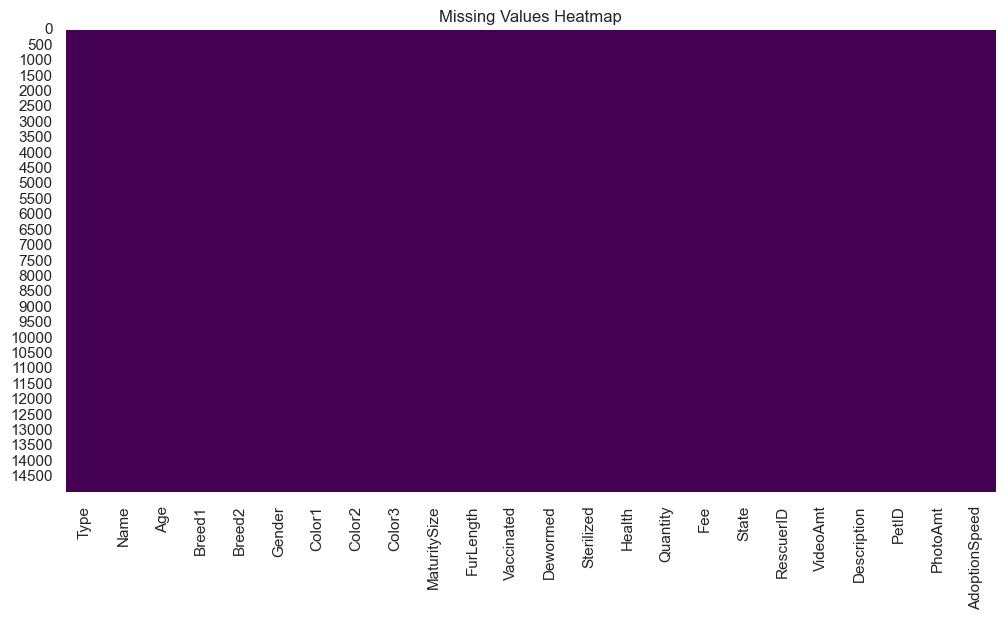

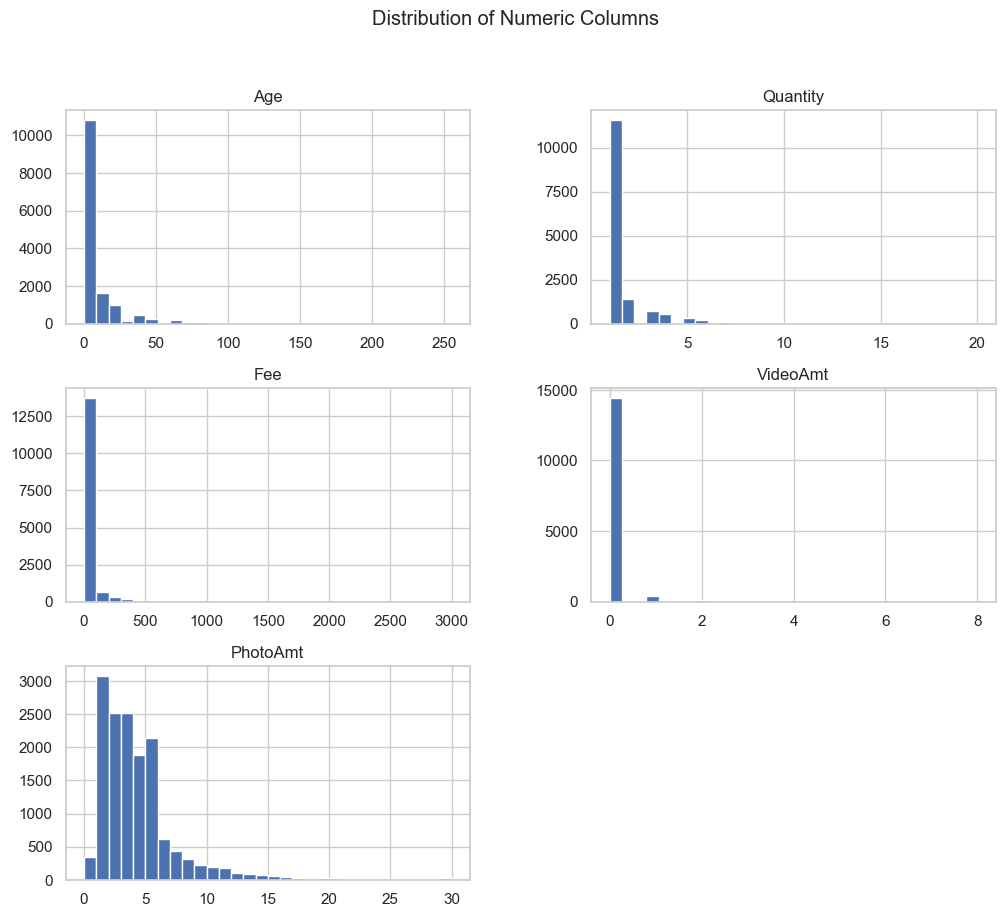

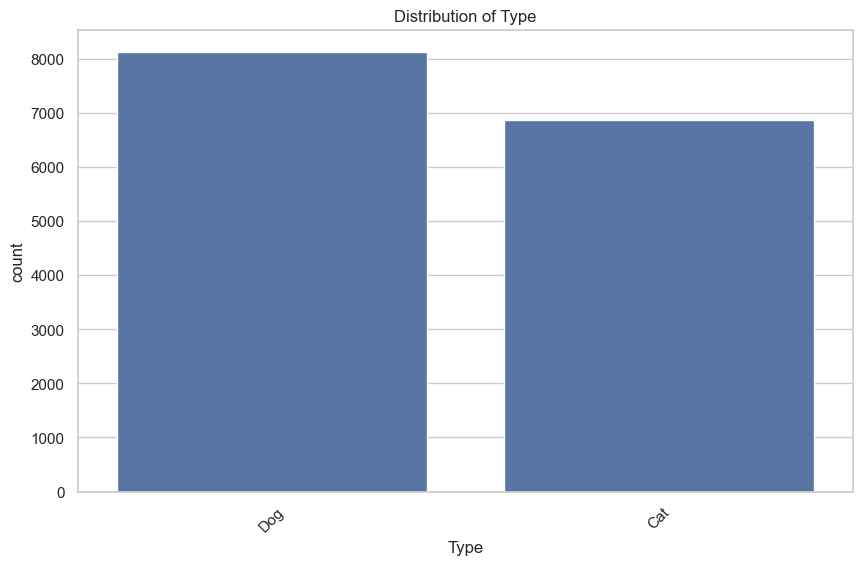

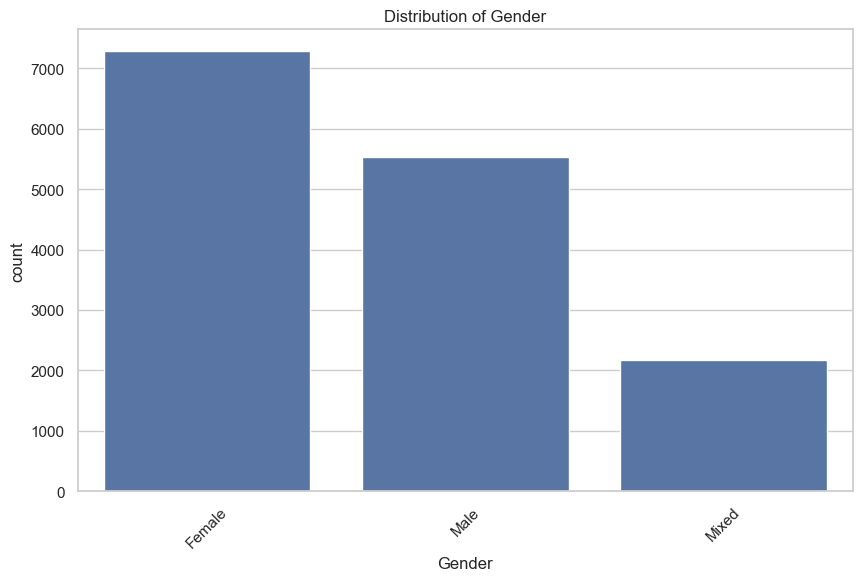

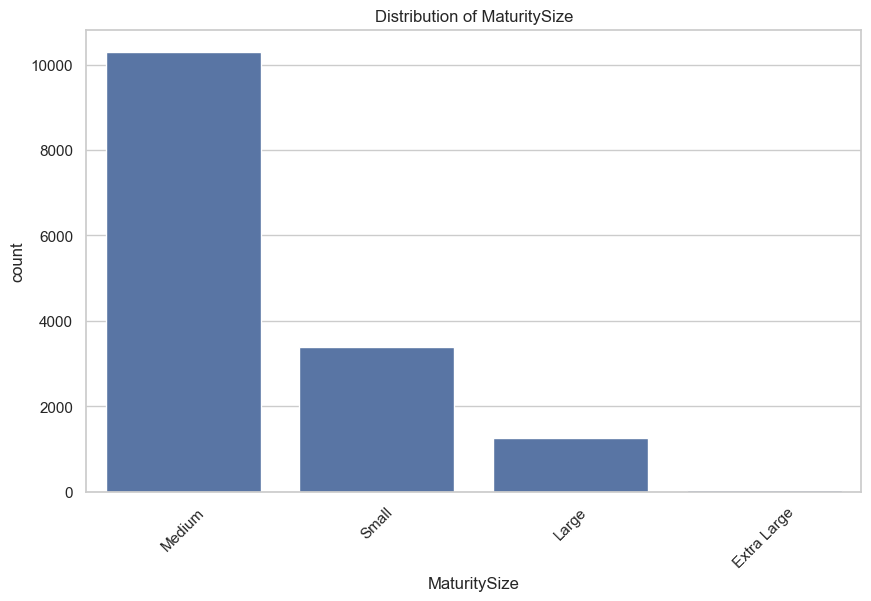

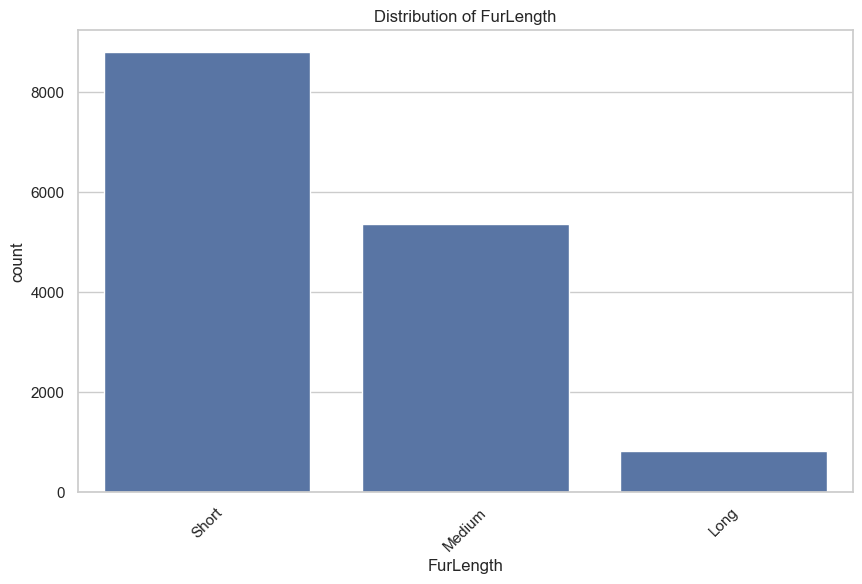

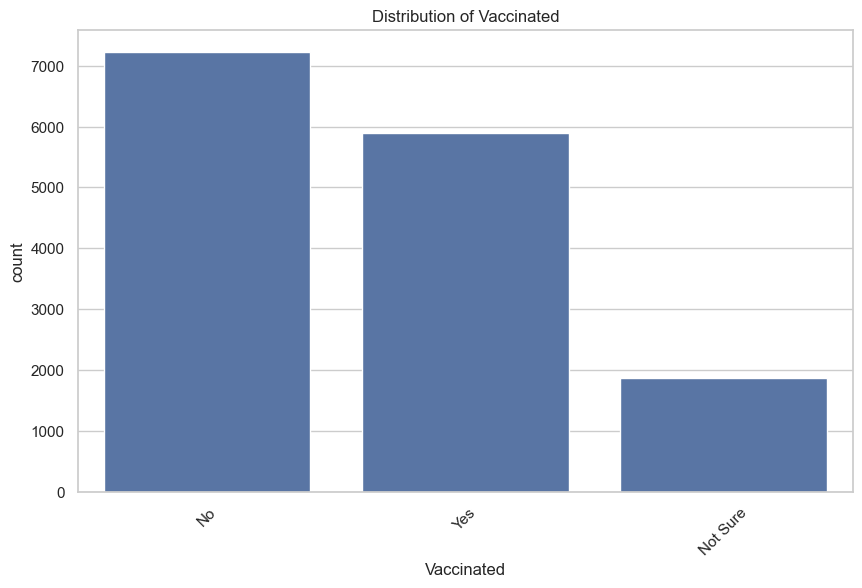

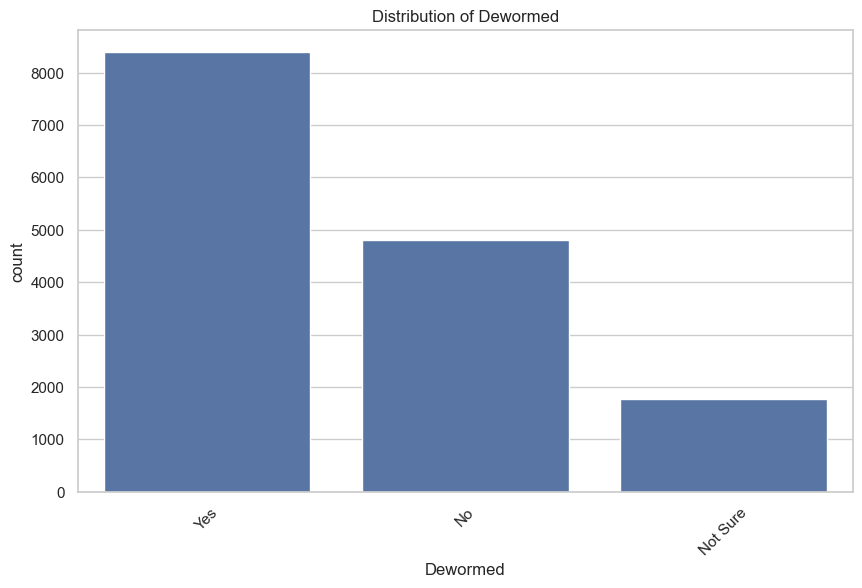

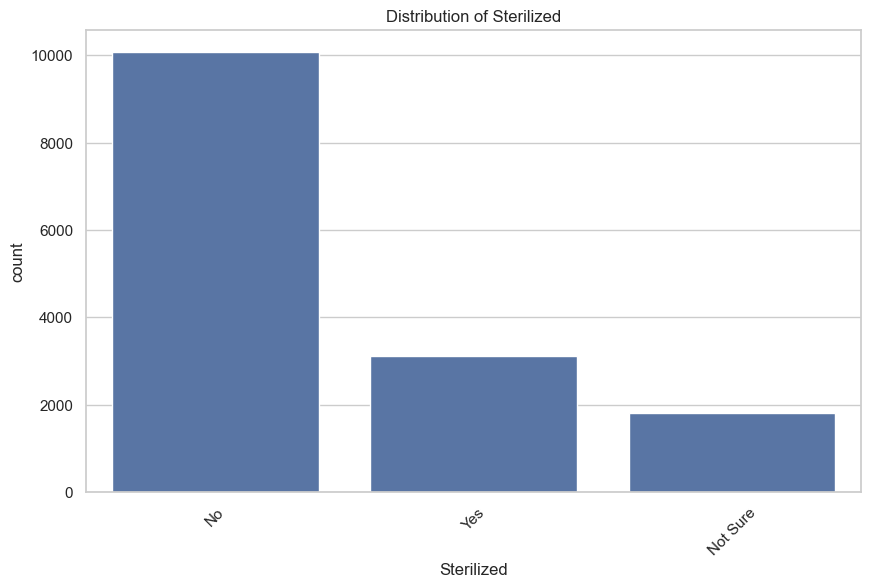

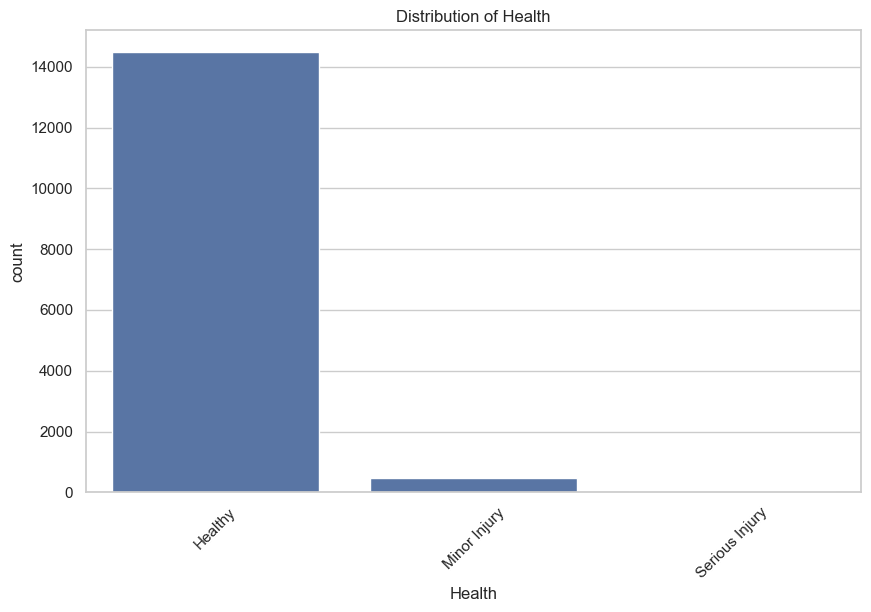

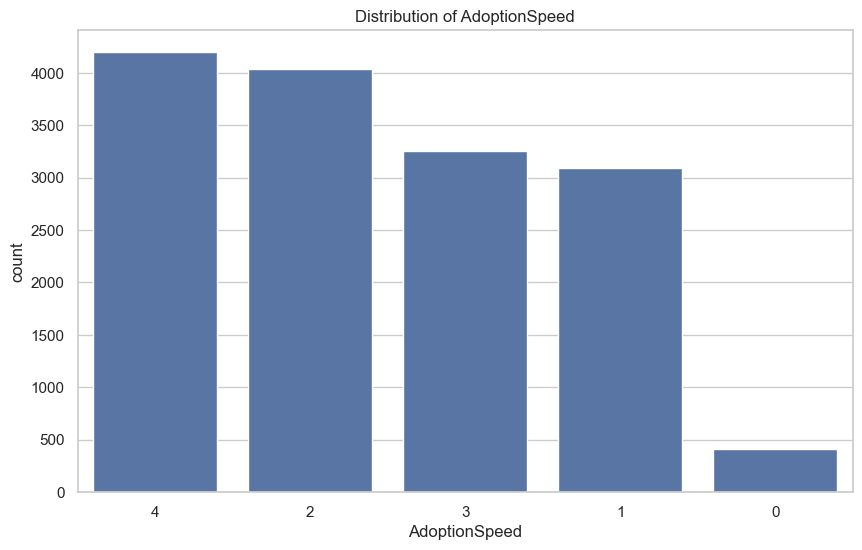

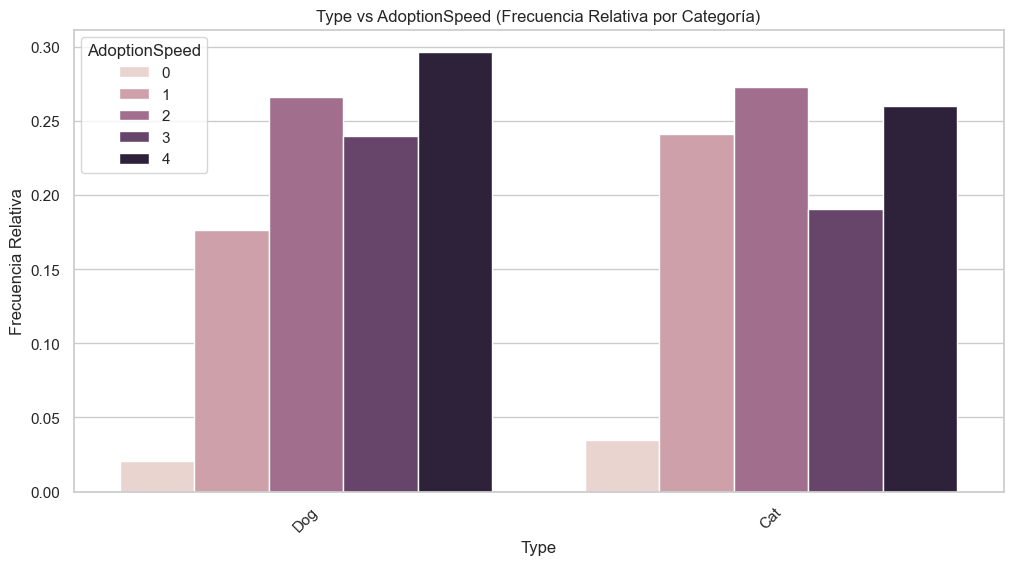

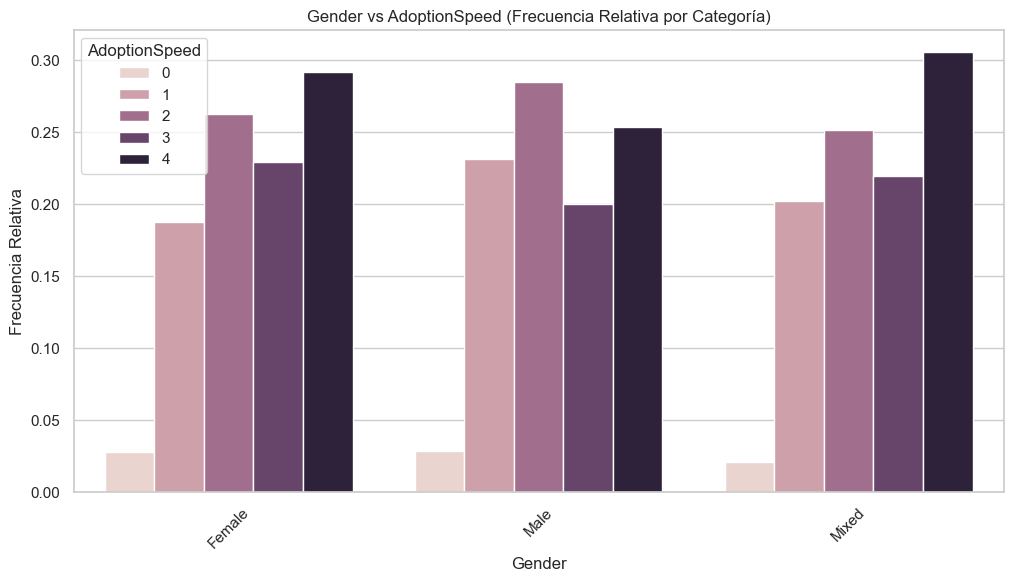

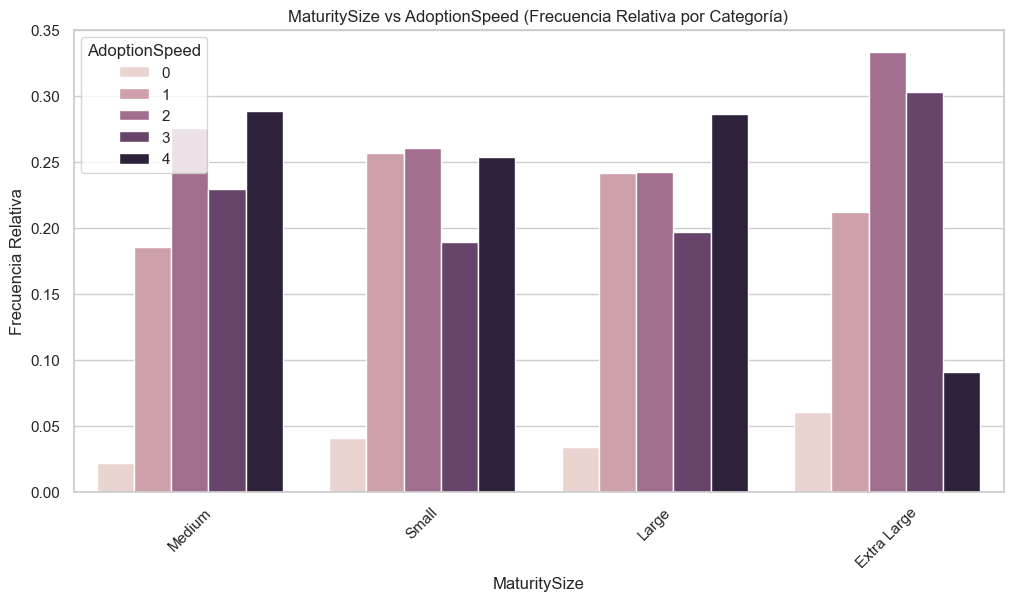

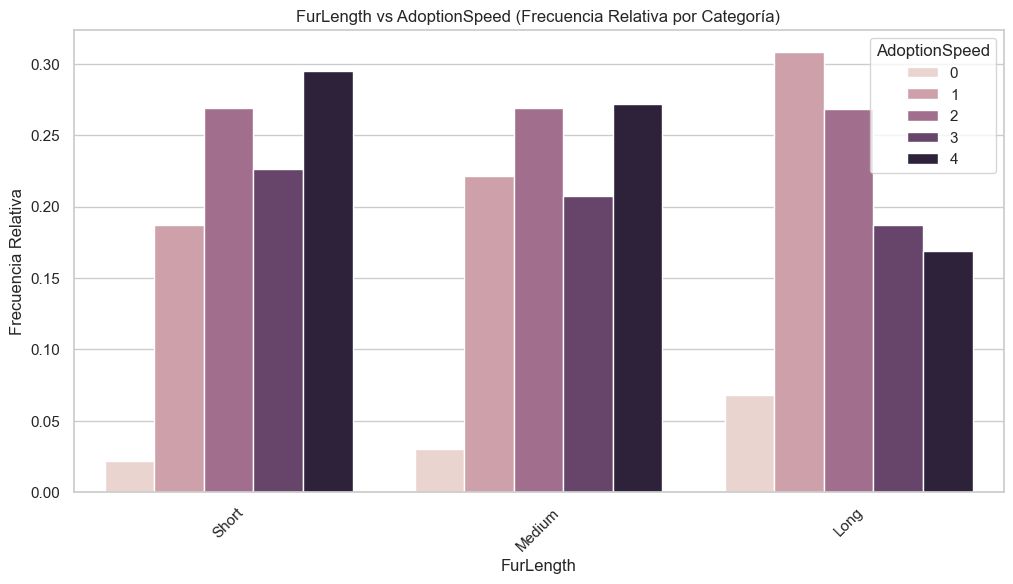

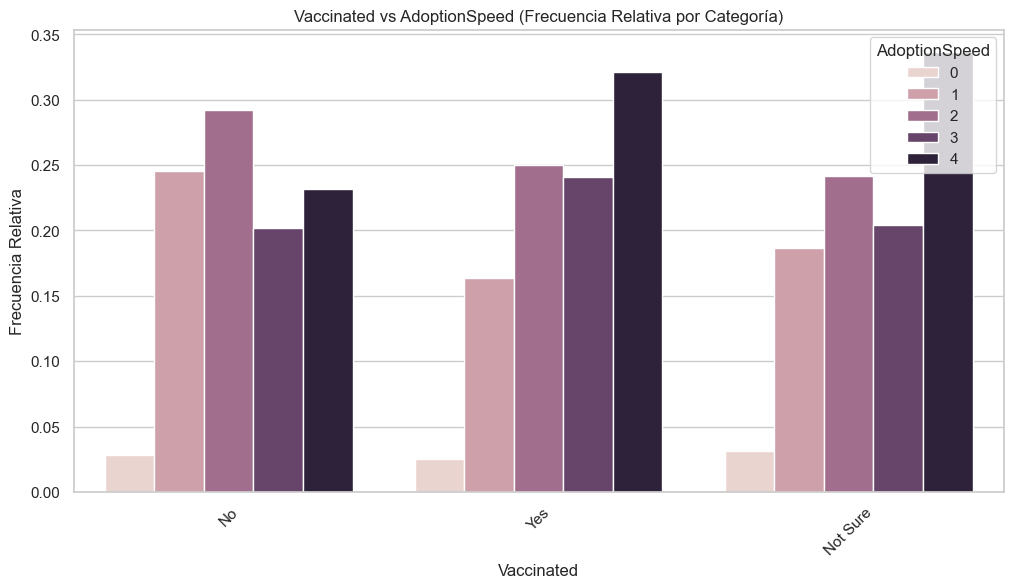

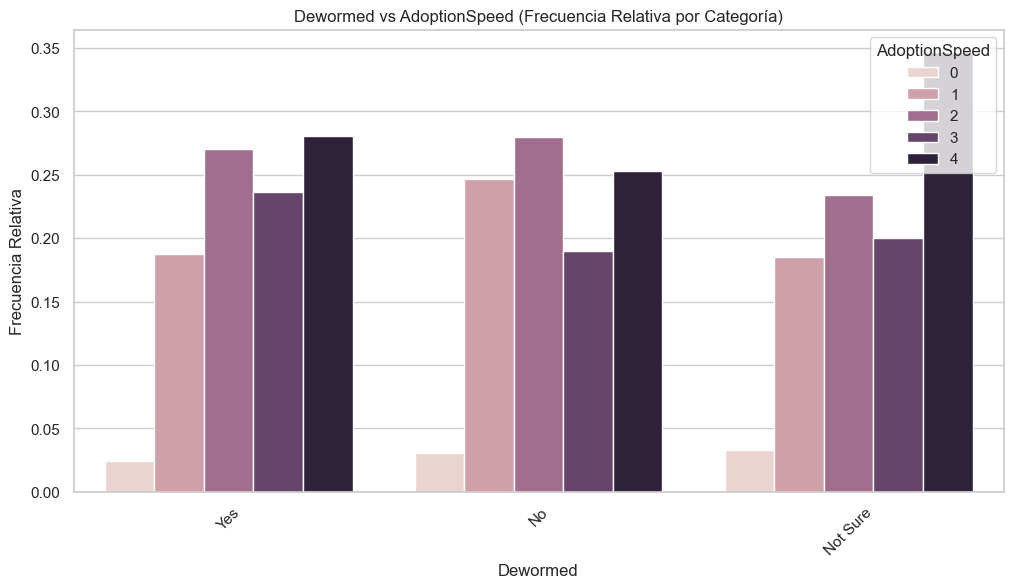

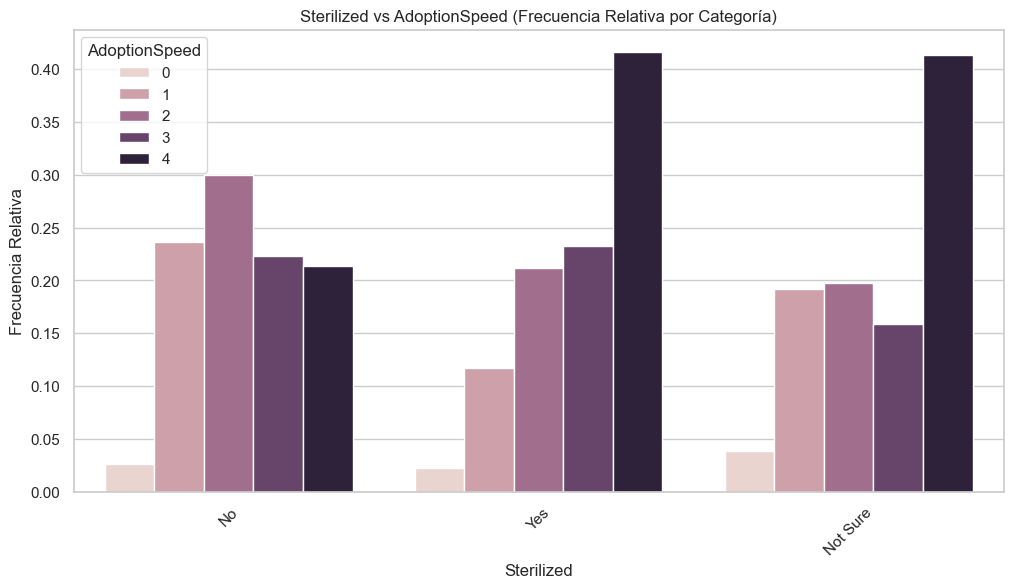

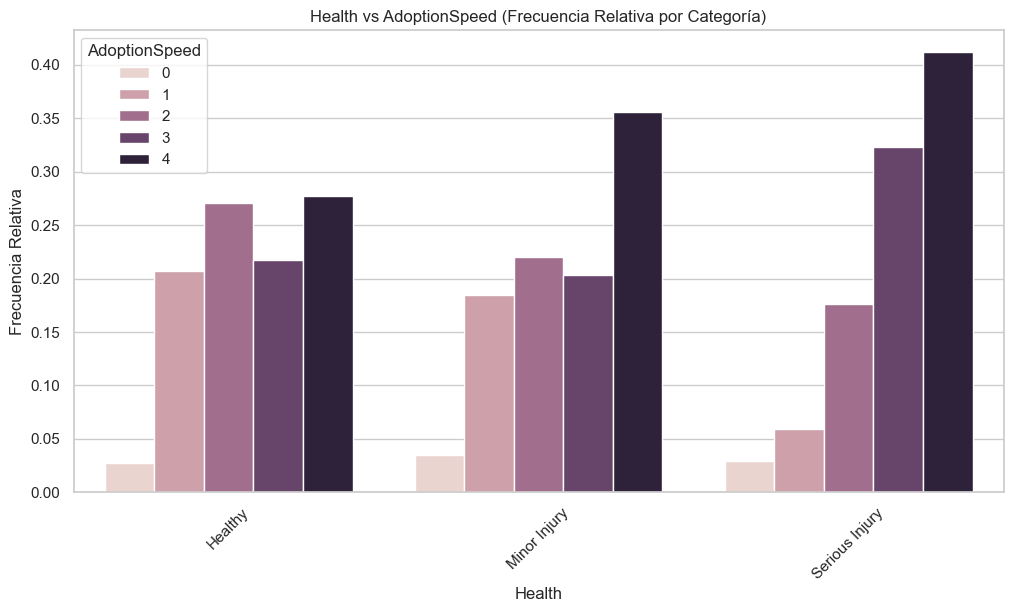

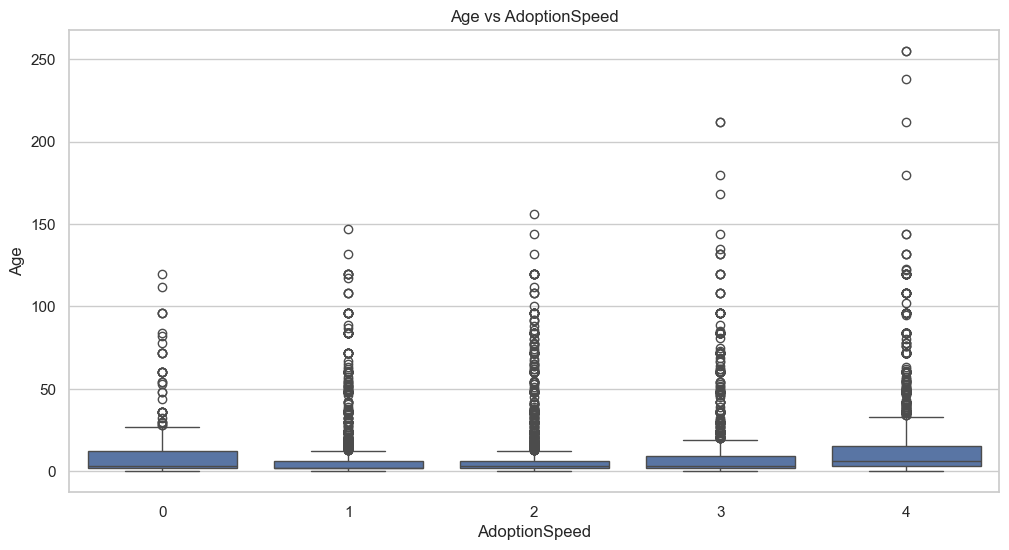

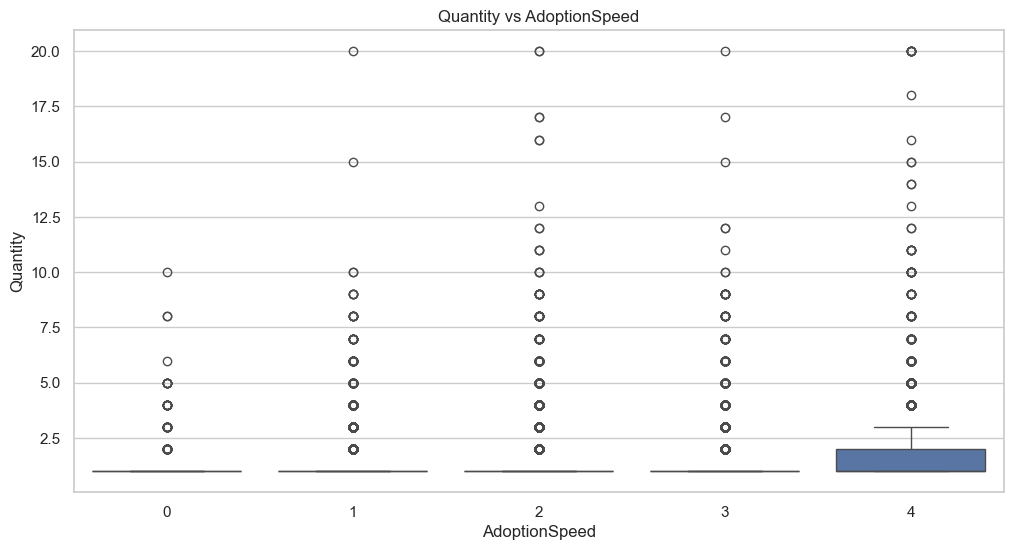

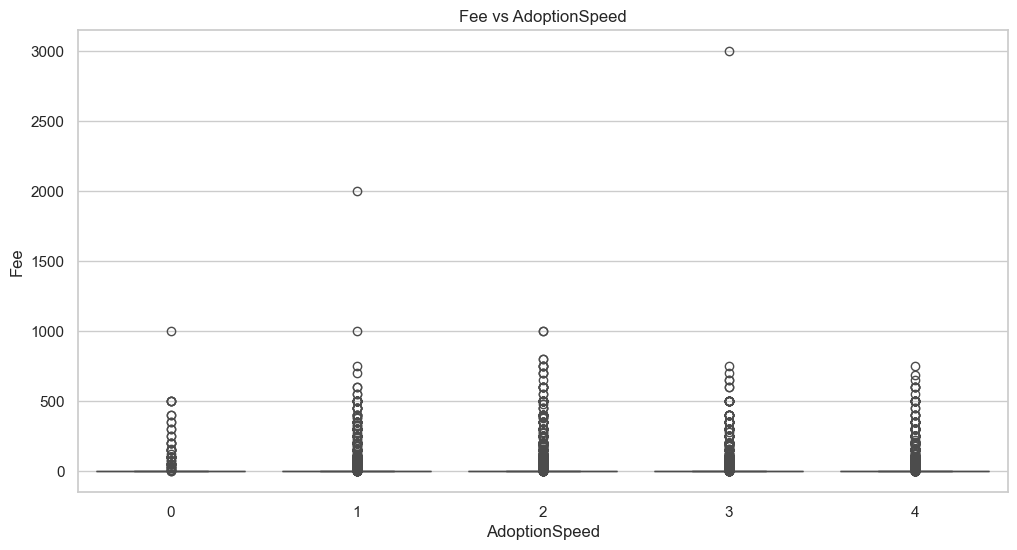

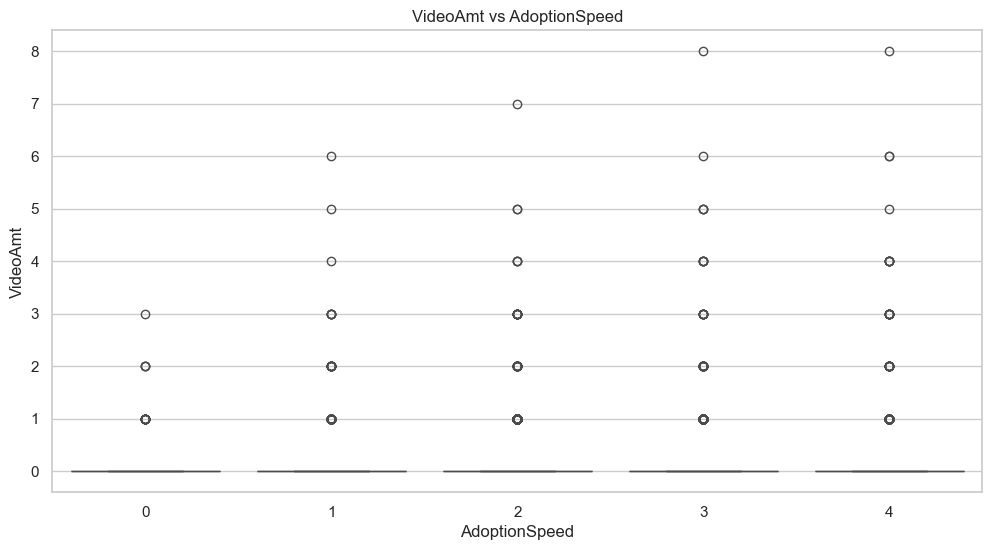

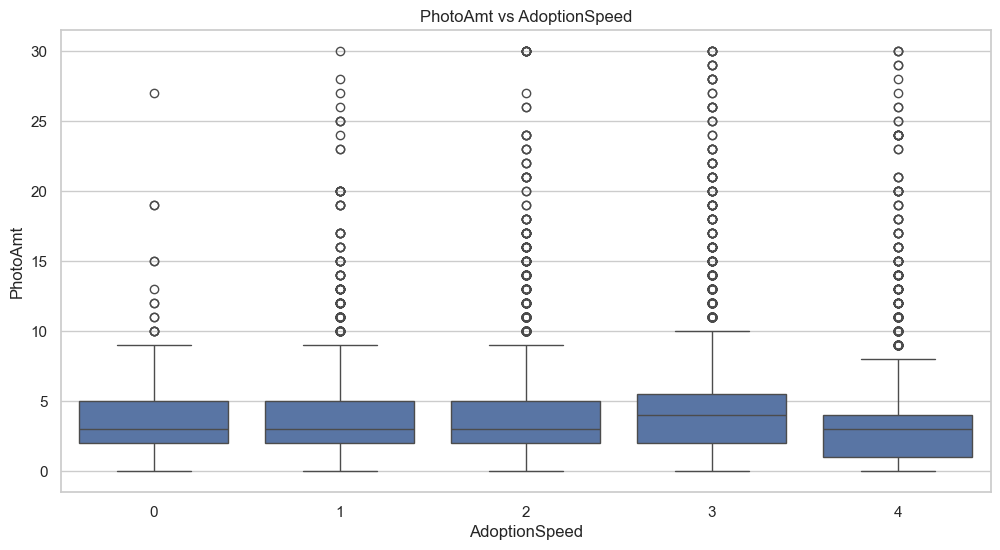

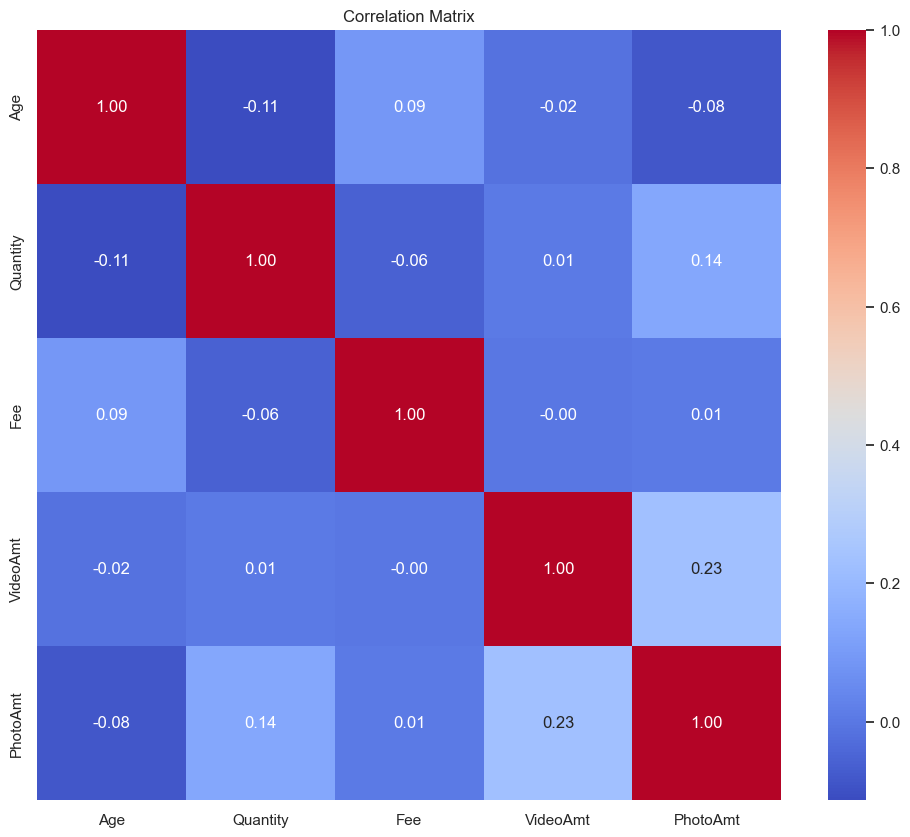

EDA completed.


In [7]:
# correr eda manual (o personalizado)
run_eda(dataset_orig)

Campos que podríamos agregar:

* Combinaciones de "dewormed" y "sterilized".

* Combinaciones de "vaccinated" y "sterilized".

* Combinaciones de "dewormed" y "vaccinated".

* Combinaciones de "vaccinated", "dewormed" y "sterilized". (FedeR estaba trabajando en el data engineering con esto)

* Edad y "sterilized" (¿edad menor a 7 años y "sterilized"? ¿Cuándo se esterilizan?).

* sin_nombre: (FedeR ya lo hizo).

* Longitud de nombres.

* Rellenar valores nulos en el campo "nombre".

* Si tiene al menos un video.

* Si tiene al menos una foto.

* analisis descripciones (FedeR)

FedeG propone agrupar graficos que muestran lo mismo juntos, ej. las distribuciones de las variables categoricas, numericas...